In [1]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 12 # 14
mpl.rcParams['legend.labelspacing'] = 0.3
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

In [3]:
nparam = 2
ValFrac = 0.2
NReal_List = [10,20]
Plots_Dir = 'plots/'
print('Using plot dir :'+Plots_Dir)

KLstats_all = {}
for NReal in NReal_List:
    File_Stem = 'poly' # 'poly','gaussmix'
    if (File_Stem == 'poly') & (nparam > 2):
        File_Stem += '_deg{0:d}'.format(nparam-1)
    if NReal != 10:
        File_Stem += '_avg{0:d}'.format(NReal)
    print('Using file stem:'+File_Stem)
    
    Arch_File = File_Stem + '/archs.pkl'
    with open(Arch_File, 'rb') as f:
        archs = pickle.load(f)  
    Complexities = list(archs.keys())#[:-1] 
    N_Archs = len(Complexities)
    # storage for median,+error,-error,complexity,Nfree,Ntrain/Nfree
    KLstats = np.zeros(N_Archs,dtype=[('KL',float),('KL+',float),('KL-',float),
                                      ('complexity',int),('Nwts',int),('freedom',float)]) 
    for a in range(N_Archs):
        complexity = Complexities[a]
        KLstats['KL'][a] = archs[complexity]['KL']
        KLstats['KL+'][a] = archs[complexity]['KL84'] - archs[complexity]['KL']
        KLstats['KL-'][a] = archs[complexity]['KL'] - archs[complexity]['KL16']
        KLstats['complexity'][a] = complexity
        KLstats['Nwts'][a] = archs[complexity]['Nwts']
        KLstats['freedom'][a] = (1-ValFrac)*complexity/archs[complexity]['Nwts']**2
    
    KLstats = np.sort(KLstats,order='complexity')

    KLstats_all[NReal] = KLstats

Using plot dir :plots/
Using file stem:poly
Using file stem:poly_avg20


In [4]:
Save_Fig = True

unique freedoms: [0.2 0.4 0.5 0.6 0.8 1.  1.5 1.8 2.  2.9 4. ]
Writing to file: plots/archs_freedom.png


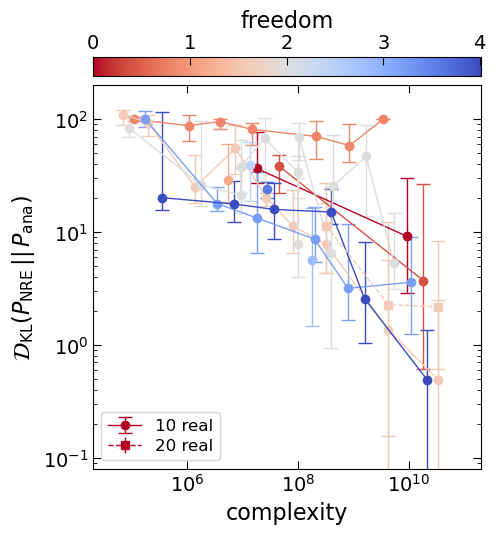

In [5]:
Freedoms = np.unique(np.round(np.concatenate((KLstats_all[10]['freedom'],KLstats_all[20]['freedom'])),1))
print('unique freedoms:',Freedoms)
CMap = plt.cm.coolwarm_r
sm = plt.cm.ScalarMappable(cmap=CMap, norm=pltcol.Normalize(vmin=0*0.999*Freedoms.min(), vmax=1.001*Freedoms.max()))

FSize = 5
fig,ax = plt.subplots(1,1,figsize=(FSize,1.2*FSize))
plt.xlim(2e4,2e11)
plt.ylim(8e-2,2e2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('complexity')
plt.ylabel('$\\mathcal{D}_{{\\rm KL}}(P_{{\\rm NRE}}\\,||\\,P_{{\\rm ana}})$')
for NReal in NReal_List:
    klstats = KLstats_all[NReal]
    cols = iter(CMap(np.linspace(0,1,Freedoms.size)))
    for free in Freedoms:
        cfree = (np.round(klstats['freedom'],1) == free)
        Label = ('10 real' if (NReal == 10) else '20 real') if (free == Freedoms.min()) else None
        col = next(cols)
        plt.errorbar(klstats['complexity'][cfree],
                     klstats['KL'][cfree],
                     yerr=np.array([klstats['KL-'][cfree],klstats['KL+'][cfree]]),
                     c=col,marker='o' if NReal==10 else 's',capsize=5,label=Label,
                     lw=1,ls='-' if NReal==10 else '--')
plt.legend(loc='lower left')

cb = plt.colorbar(sm,ax=ax,orientation='horizontal',location='top',pad=0.02)
cb.set_label('freedom')
# cb.set_label('$N_{{\\rm train}} \\,/\\, N_{{\\rm wts}}$')

if Save_Fig:
    filename = 'archs_freedom.png'
    print('Writing to file: '+Plots_Dir+filename)
    plt.savefig(Plots_Dir+filename,bbox_inches='tight')
else:
    plt.show()

Writing to file: plots/archs_Nwts.png


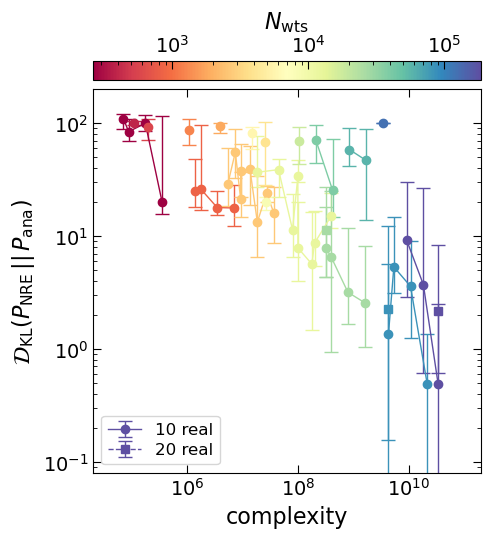

In [6]:
Wts = np.unique(np.concatenate((KLstats_all[10]['Nwts'],KLstats_all[20]['Nwts'])))
CMap = plt.cm.Spectral
sm = plt.cm.ScalarMappable(cmap=CMap, norm=pltcol.LogNorm(vmin=0.99*Wts.min(), vmax=1.01*Wts.max()))

FSize = 5
fig,ax = plt.subplots(1,1,figsize=(FSize,1.2*FSize))
plt.xlim(2e4,2e11)
plt.ylim(8e-2,2e2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('complexity')
plt.ylabel('$\\mathcal{D}_{{\\rm KL}}(P_{{\\rm NRE}}\\,||\\,P_{{\\rm ana}})$')
for NReal in NReal_List:
    klstats = KLstats_all[NReal]
    cols = iter(CMap(np.linspace(0,1,Wts.size)))
    for wt in Wts:
        cwt = (klstats['Nwts'] == wt)
        Label = ('10 real' if (NReal == 10) else '20 real') if (wt == Wts.max()) else None
        col = next(cols)
        plt.errorbar(klstats['complexity'][cwt],
                     klstats['KL'][cwt],
                     yerr=np.array([klstats['KL-'][cwt],klstats['KL+'][cwt]]),
                     c=col,marker='o' if NReal==10 else 's',capsize=5,label=Label,
                     lw=1,ls='-' if NReal==10 else '--')
plt.legend(loc='lower left')

cb = plt.colorbar(sm,ax=ax,orientation='horizontal',location='top',pad=0.02)
cb.set_label('$N_{{\\rm wts}}$')

if Save_Fig:
    filename = 'archs_Nwts.png'
    print('Writing to file: '+Plots_Dir+filename)
    plt.savefig(Plots_Dir+filename,bbox_inches='tight')
else:
    plt.show()

Writing to file: plots/archs_Nsamp.png


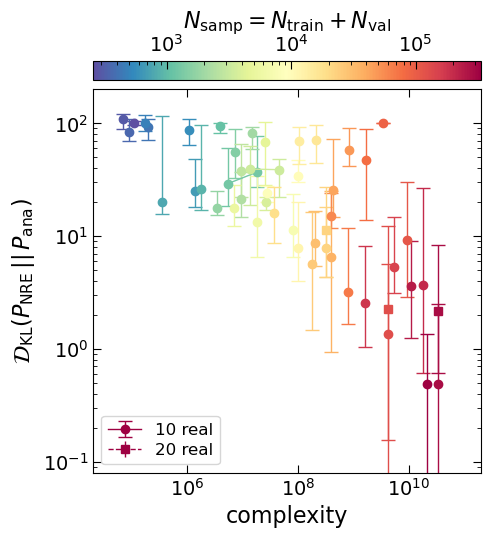

In [7]:
NSamps = np.unique(np.concatenate((KLstats_all[10]['complexity']//KLstats_all[10]['Nwts'],
                                   KLstats_all[20]['complexity']//KLstats_all[20]['Nwts'])))
CMap = plt.cm.Spectral_r
sm = plt.cm.ScalarMappable(cmap=CMap, norm=pltcol.LogNorm(vmin=0.99*NSamps.min(), vmax=1.01*NSamps.max()))

FSize = 5
fig,ax = plt.subplots(1,1,figsize=(FSize,1.2*FSize))
plt.xlim(2e4,2e11)
plt.ylim(8e-2,2e2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('complexity')
plt.ylabel('$\\mathcal{D}_{{\\rm KL}}(P_{{\\rm NRE}}\\,||\\,P_{{\\rm ana}})$')
eps = 1e-1
for NReal in NReal_List:
    klstats = KLstats_all[NReal]
    cols = iter(CMap(np.linspace(0,1,NSamps.size)))
    for nsamp in NSamps:
        cnsamp = (klstats['complexity']//klstats['Nwts'] == nsamp)
        Label = ('10 real' if (NReal == 10) else '20 real') if (nsamp == NSamps.max()) else None
        col = next(cols)
        plt.errorbar(klstats['complexity'][cnsamp],
                     klstats['KL'][cnsamp],
                     yerr=np.array([klstats['KL-'][cnsamp],klstats['KL+'][cnsamp]]),
                     c=col,marker='o' if NReal==10 else 's',capsize=5,label=Label,
                     lw=1,ls='-' if NReal==10 else '--')
plt.legend(loc='lower left')

cb = plt.colorbar(sm,ax=ax,orientation='horizontal',location='top',pad=0.02)
cb.set_label('$N_{{\\rm samp}} = N_{{\\rm train}} + N_{{\\rm val}}$')
# cb.set_ticks(np.arange(1,n_basis+1))

if Save_Fig:
    filename = 'archs_Nsamp.png'
    print('Writing to file: '+Plots_Dir+filename)
    plt.savefig(Plots_Dir+filename,bbox_inches='tight')
else:
    plt.show()

unique complexities: [      70225       87715      108420      175430      194481      351125
     1063575     1394761     1743156     3486312     3920325     5442000
     6973805     7403841     9251400     9254121    13605000    15033825
    17882000    18508242    25277637    27050401    27210000    37019205
    44705000    79941481    99924616   100139200   104353677   178820000
   199849232   211979670   320445801   399707405   400552776   423977757
   801105552   854538470  1602229005  1709113917  3431432070  4329771601
  5412198051  9235050000 10824396102 18470100000 21648858005 34114459401]
Writing to file: plots/archs_complexity.png


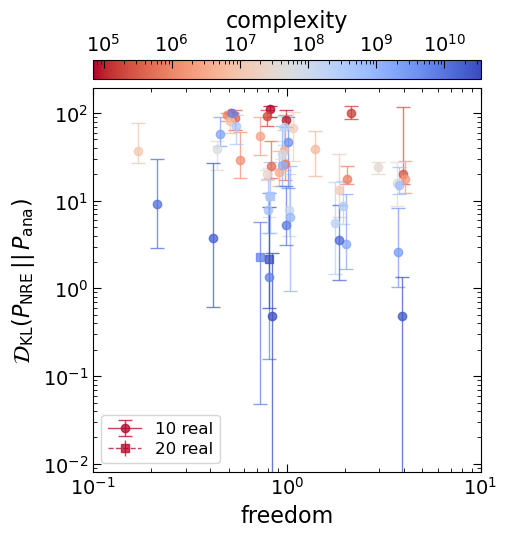

In [8]:
Complexes = np.unique(np.concatenate((KLstats_all[10]['complexity'],KLstats_all[20]['complexity'])))
print('unique complexities:',Complexes)
CMap = plt.cm.coolwarm_r
sm = plt.cm.ScalarMappable(cmap=CMap, norm=pltcol.LogNorm(vmin=0.999*Complexes.min(), vmax=1.001*Complexes.max()))

rng = np.random.RandomState(42)

FSize = 5
fig,ax = plt.subplots(1,1,figsize=(FSize,1.2*FSize))
plt.xlim(1e-1,1e1)
# plt.ylim(8e-2,2e2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freedom')
plt.ylabel('$\\mathcal{D}_{{\\rm KL}}(P_{{\\rm NRE}}\\,||\\,P_{{\\rm ana}})$')
for NReal in NReal_List:
    klstats = KLstats_all[NReal]
    cols = iter(CMap(np.linspace(0,1,Complexes.size)))
    for comp in Complexes:
        ccomp = (klstats['complexity'] == comp)
        Label = ('10 real' if (NReal == 10) else '20 real') if (comp == Complexes.min()) else None
        col = next(cols)
        plt.errorbar(klstats['freedom'][ccomp]*(1+0.05*rng.randn(np.where(ccomp)[0].size)),
                     klstats['KL'][ccomp],
                     yerr=np.array([klstats['KL-'][ccomp],klstats['KL+'][ccomp]]),
                     c=col,marker='o' if NReal==10 else 's',capsize=5,label=Label,
                     lw=1,ls='-' if NReal==10 else '--',alpha=0.75)
plt.legend(loc='lower left')

cb = plt.colorbar(sm,ax=ax,orientation='horizontal',location='top',pad=0.02)
cb.set_label('complexity')
# cb.set_label('$N_{{\\rm samp}} \\,\\times\\, N_{{\\rm wts}}$')

if Save_Fig:
    filename = 'archs_complexity.png'
    print('Writing to file: '+Plots_Dir+filename)
    plt.savefig(Plots_Dir+filename,bbox_inches='tight')
else:
    plt.show()

Writing to file: plots/archs_Nwts_Nsamp.png


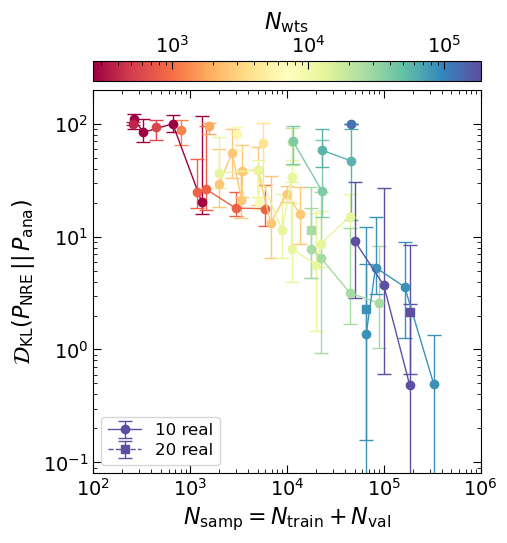

In [9]:
Wts = np.unique(np.concatenate((KLstats_all[10]['Nwts'],KLstats_all[20]['Nwts'])))
CMap = plt.cm.Spectral
sm = plt.cm.ScalarMappable(cmap=CMap, norm=pltcol.LogNorm(vmin=0.99*Wts.min(), vmax=1.01*Wts.max()))

FSize = 5
fig,ax = plt.subplots(1,1,figsize=(FSize,1.2*FSize))
plt.xlim(1e2,1e6)
plt.ylim(8e-2,2e2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$N_{{\\rm samp}} = N_{{\\rm train}} + N_{{\\rm val}}$')
plt.ylabel('$\\mathcal{D}_{{\\rm KL}}(P_{{\\rm NRE}}\\,||\\,P_{{\\rm ana}})$')
for NReal in NReal_List:
    klstats = KLstats_all[NReal]
    cols = iter(CMap(np.linspace(0,1,Wts.size)))
    for wt in Wts:
        cwt = (klstats['Nwts'] == wt)
        Label = ('10 real' if (NReal == 10) else '20 real') if (wt == Wts.max()) else None
        col = next(cols)
        plt.errorbar(klstats['complexity'][cwt]//klstats['Nwts'][cwt],
                     klstats['KL'][cwt],
                     yerr=np.array([klstats['KL-'][cwt],klstats['KL+'][cwt]]),
                     c=col,marker='o' if NReal==10 else 's',capsize=5,label=Label,
                     lw=1,ls='-' if NReal==10 else '--')
plt.legend(loc='lower left')

cb = plt.colorbar(sm,ax=ax,orientation='horizontal',location='top',pad=0.02)
cb.set_label('$N_{{\\rm wts}}$')

if Save_Fig:
    filename = 'archs_Nwts_Nsamp.png'
    print('Writing to file: '+Plots_Dir+filename)
    plt.savefig(Plots_Dir+filename,bbox_inches='tight')
else:
    plt.show()